First we install keras-tuner and suppress output

In [1]:
!pip install keras-tuner &>/dev/null

Then we import basic libraries and set basic quantities for this learning task

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
# default font
plt.rcParams['font.size'] = 13

# number of data points, i.e., database size
N=2000
# size of each sample
L=8
# box size
B=10

!mkdir DATA

%run useful.py

mkdir: cannot create directory ‘DATA’: File exists


## Creation of data
The following cell creates the dataset and plots it

2 5 1


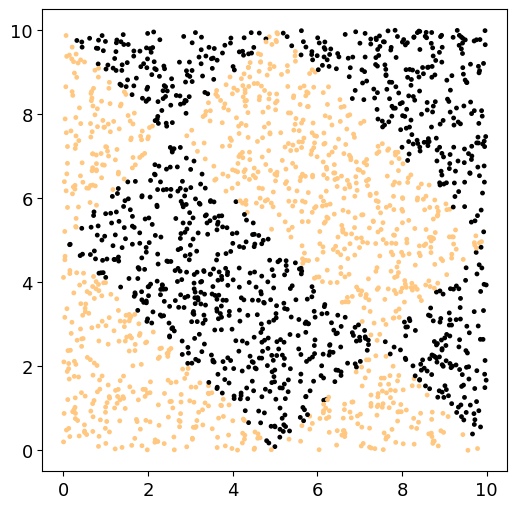

./DATA/data-for-DNN_type3_L8.dat
./DATA/labels-for-DNN_type3_L8.dat


In [3]:
TYPE=3

# random seed for reproducibility
np.random.seed(12345)
print(np.random.randint(0,10),np.random.randint(0,10),np.random.randint(0,10))

x,y = (np.random.random((N,L)))*B, np.zeros(N)
for i in range(N):
    # label data according to a nonlinear function "f"
    y[i] = NF(x[i],B,TYPE)

plot_data(x,y)

fn=filename("data",L,TYPE)
np.savetxt(fn,x)
print(fn)
fn=filename("labels",L,TYPE)
np.savetxt(fn,y,fmt="%d")
print(fn)

# Analysis with Keras of 2D data

In [4]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Dropout
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

import matplotlib as mpl
import matplotlib.pyplot as plt
# default font
plt.rcParams['font.size'] = 13

from sklearn.preprocessing import StandardScaler

%run useful.py

# training data
perc_train = 0.8

2025-02-27 09:03:07.706451: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 09:03:07.765823: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-02-27 09:03:07.831248: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740643387.899494  510644 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740643387.922986  510644 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-27 09:03:08.084815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## Read data

In [5]:
# Keras works with numpy arrays: just use them from the start

TYPE=3
# data point size
L=8
# span of each component
B=10
x = np.loadtxt(filename("data",L,TYPE), delimiter=' ')
y = np.loadtxt(filename("labels",L,TYPE), delimiter=' ')
y = y.astype("int")
#print(x.shape)
N = len(x)
# average and std.dev.
x_mean = np.mean(x,axis=0)
x_std  = np.std(x,axis=0)


# dim. of a sample
L = len(x[0])
#print(L)

#for i in range(5):
    #print(x[i],y[i])

N_train = int(perc_train * N)
#print(f'data: {N}\ntrain: {N_train}')

#plot_data(x,y)

## Standardize data

In [6]:
print("before rescaling:\nmean value=", x_mean,"\nstd. dev.=",x_std)
def Standardize(x,m,s):
    """
    rescale each component using its mean and standard deviation
    """
    N = len(x)
    # assuming len(m)=len(s)=len(x[0])
    mm,ss = np.tile(m,(N,1)), np.tile(s,(N,1))
    return (x-mm)/ss
x = Standardize(x,x_mean,x_std)
print("after rescaling:\nmean value=", x.mean(axis=0),"\nstd. dev.=",x.std(axis=0))

before rescaling:
mean value= [5.01860571 5.01726228 5.02153857 5.08947968 5.10248206 5.03670082
 4.88645281 5.05411547] 
std. dev.= [2.86912607 2.89535235 2.87312372 2.86324409 2.90278676 2.91948328
 2.92549254 2.89281292]
after rescaling:
mean value= [ 2.53633226e-15  9.27924404e-16 -1.44884105e-15 -2.38371996e-15
 -2.85274582e-15 -2.02196593e-15 -1.09010023e-15 -1.53632662e-15] 
std. dev.= [1. 1. 1. 1. 1. 1. 1. 1.]


## Split train and test data

In [7]:
(x_train, y_train) = (x[0:N_train],y[0:N_train])
(x_valid, y_valid) = (x[N_train:],y[N_train:])
print("Train:",len(x_train),"points","\t Validation:",len(x_valid),"points\n")

print(f"Train set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_train[y_train == 1])/len(x_train)*100,2)}% \t {round(len(x_train[y_train == 0])/len(x_train)*100,2)}%\n")
print(f"Valid set fraction of datapoints:")
print(f"ones \t zeros")
print(f"{round(len(x_valid[y_valid == 1])/len(x_valid)*100,2)}% \t {round(len(x_valid[y_valid == 0])/len(x_valid)*100,2)}%\n")


Train: 1600 points 	 Validation: 400 points

Train set fraction of datapoints:
ones 	 zeros
50.06% 	 49.94%

Valid set fraction of datapoints:
ones 	 zeros
47.0% 	 53.0%



## Define model with Keras

Here we define the bulid_model function

In [8]:
def build_model(hp):
    model = Sequential()
    n_hidden_layers = 3
    
    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))

    # hidden layers
    for i in range(n_hidden_layers):
        model.add(
            Dense(
            20, # num of neurons
            activation = hp.Choice(f"activation_{i}",['relu','tanh','sigmoid','elu'])
            )
        )
        model.add(
            Dropout(
                rate = hp.Float(f"dropout_rate_{i}",min_value=0,max_value=0.3,step=0.1)
            )
        )

    # output layer
    model.add(Dense(1,activation='sigmoid'))
    
    # choice of optimizer
    optimizer_choice = hp.Choice("optimizer", ['Adam', 'RMSprop', 'Nesterov'])

    # each optimizer has to have a learning rate well-defined
    if optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate=hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, sampling="log")
        )
    elif optimizer_choice == 'RMSprop':
        optimizer = RMSprop(
            learning_rate=hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, sampling="log")
        )
    else:
        optimizer = SGD(
            learning_rate=hp.Float("learning_rate", min_value=1e-6, max_value=1e-1, sampling="log"),
            momentum=hp.Float("momentum", min_value=0.0, max_value=1.0),
            nesterov=True
        )

    # compilation of the model
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

trial = build_model(kt.HyperParameters())
# print a summary of the model
trial.summary()

/home/lucab/Desktop/LCP B course/coding_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-02-27 09:03:12.577525: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            72 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 20)             │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 20)             │           420 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,113 (4.35 KB)

 Trainable params: 1,113 (4.35 KB)

 Non-trainable params: 0 (0.00 B)

## Training

Here we setup the tuner for the RandomSearch. max_trials is number of combinations to try

In [9]:
tuner = kt.RandomSearch(
    hypermodel = build_model,
    objective = "val_accuracy",
    max_trials = 10, # parameters permutations are 240
    executions_per_trial = 1,
)


Reloading Tuner from ./untitled_project/tuner0.json


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 9
activation_0 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_1 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
activation_2 (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh', 'sigmoid', 'elu'], 'ordered': False}
dropout_rate_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'RMSprop', 'Nesterov'], 'ordered': False}
learning_rate (Float)
{'default': 1e-06, 'conditions': [], 'min_value': 1

In [11]:
nepoch = 400
tuner.search(x_train,y_train,epochs=nepoch,validation_data=(x_valid,y_valid))

In [12]:
import pandas as pd

trials = tuner.oracle.trials

results = []
for trial_id, trial in trials.items():
    if "val_accuracy" in trial.metrics.metrics:
        best_val_acc = trial.metrics.metrics["val_accuracy"].get_best_value()
        results.append({
            "trial_id": trial_id,
            "best_val_accuracy": best_val_acc,  
            "hyperparameters": trial.hyperparameters.values
        })

df_results = pd.DataFrame(results)
print(df_results.sort_values(by="best_val_accuracy", ascending=False))

  trial_id  best_val_accuracy  \
3       02             0.9775   
0       03             0.9675   
9       09             0.8950   
6       06             0.7725   
8       04             0.7175   
1       00             0.5650   
2       05             0.5650   
4       01             0.5300   
5       07             0.5300   
7       08             0.5300   

                                     hyperparameters  
3  {'activation_0': 'sigmoid', 'dropout_rate_0': ...  
0  {'activation_0': 'relu', 'dropout_rate_0': 0.1...  
9  {'activation_0': 'tanh', 'dropout_rate_0': 0.2...  
6  {'activation_0': 'tanh', 'dropout_rate_0': 0.0...  
8  {'activation_0': 'relu', 'dropout_rate_0': 0.2...  
1  {'activation_0': 'tanh', 'dropout_rate_0': 0.0...  
2  {'activation_0': 'tanh', 'dropout_rate_0': 0.2...  
4  {'activation_0': 'sigmoid', 'dropout_rate_0': ...  
5  {'activation_0': 'sigmoid', 'dropout_rate_0': ...  
7  {'activation_0': 'elu', 'dropout_rate_0': 0.2,...  


In [13]:
thresh = max(df_results["best_val_accuracy"]) - 0.1

selected_results = df_results[df_results["best_val_accuracy"] > thresh]
print(selected_results['trial_id'])
print('selected models:',len(selected_results))
selected_trial_ids = set(selected_results["trial_id"].tolist())

candidate_models = [entry for entry in results if entry['trial_id'] in selected_trial_ids]
#print(f'\n {candidate_models}')
print('selected models ids:',[entry["trial_id"] for entry in candidate_models])

0    03
3    02
9    09
Name: trial_id, dtype: object
selected models: 3
selected models ids: ['03', '02', '09']


## Performing K-fold cross validation for each selected model

In [14]:
def create_model(hyperparams):
    model = keras.Sequential()

    # input layer
    model.add(Dense(L,input_shape=(L,),activation='relu'))
    
    # First layer 
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_0']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_0']))

    # Second layer
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_1']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_1']))

    # Third layer 
    model.add(keras.layers.Dense(20, activation=hyperparams['activation_2']))
    model.add(keras.layers.Dropout(hyperparams['dropout_rate_2']))

    # Output layer 
    model.add(keras.layers.Dense(1, activation="sigmoid"))

    
    if hyperparams["optimizer"] == "RMSprop":
        optimizer = keras.optimizers.RMSprop(learning_rate=hyperparams["learning_rate"], momentum=hyperparams["momentum"])
    elif hyperparams["optimizer"] == "Adam":
        optimizer = keras.optimizers.Adam(learning_rate=hyperparams["learning_rate"])
    elif hyperparams["optimizer"] == "SGD":
        optimizer = keras.optimizers.SGD(learning_rate=hyperparams["learning_rate"], momentum=hyperparams["momentum"])
    else:
        raise ValueError("Unsupported optimizer!")

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [22]:
from sklearn.model_selection import KFold
import numpy as np
from tensorflow.keras.models import Sequential
import time

k = 5 # number of folds
kfold_nepoch = 400 # number of epoch per each kfold training step
kf = KFold(n_splits = k, shuffle = True, random_state = 42)

fold_accuracies = [] # store results

for model in candidate_models:
    #print(candidate_models[int(model["trial_id"])]["hyperparameters"])
    #print(model["trial_id"],model["hyperparameters"])
    hyperparams = model["hyperparameters"]
    tbt_model = create_model(hyperparams)

    start_kfold_time = time.time()
    for train_index, val_index in kf.split(x):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        tbt_model.fit(x_train, y_train, epochs = kfold_nepoch, batch_size = 32, verbose = 0)

        val_loss, val_acc = tbt_model.evaluate(x_val, y_val, verbose = 2)
        print(f"Fold accuracy: {val_acc:.4f}")
        fold_accuracies.append(val_acc)
    
    mean_acc = np.mean(fold_accuracies)
    std_acc = np.std(fold_accuracies)
    model["k_fold_val_acc"] = mean_acc
    model["k_fold_val_acc_error"] = std_acc
    
    print(f"\n K-fold training took {round(time.time()-start_kfold_time,3)}s")
    print(f"Results for model index {model["trial_id"]}, accuracy = {round(mean_acc,2)} +- {round(std_acc,2)}\n")
   
    fold_accuracies = []

13/13 - 0s - 13ms/step - accuracy: 0.9650 - loss: 0.1844
Fold accuracy: 0.9650
13/13 - 0s - 4ms/step - accuracy: 0.9700 - loss: 0.1055
Fold accuracy: 0.9700
13/13 - 0s - 4ms/step - accuracy: 0.9700 - loss: 0.0932
Fold accuracy: 0.9700
13/13 - 0s - 4ms/step - accuracy: 0.9750 - loss: 0.0607
Fold accuracy: 0.9750
13/13 - 0s - 4ms/step - accuracy: 0.9750 - loss: 0.0520
Fold accuracy: 0.9750

 K-fold training took 255.92s
Results for model index 03, accuracy = 0.9710000157356262 +- 0.003741672934492183

13/13 - 0s - 13ms/step - accuracy: 0.9275 - loss: 0.2351
Fold accuracy: 0.9275
13/13 - 0s - 4ms/step - accuracy: 0.9300 - loss: 0.2105
Fold accuracy: 0.9300
13/13 - 0s - 4ms/step - accuracy: 0.9600 - loss: 0.2318
Fold accuracy: 0.9600
13/13 - 0s - 4ms/step - accuracy: 0.9550 - loss: 0.2734
Fold accuracy: 0.9550
13/13 - 0s - 4ms/step - accuracy: 0.9550 - loss: 0.2443
Fold accuracy: 0.9550

 K-fold training took 247.071s
Results for model index 02, accuracy = 0.9454999923706054 +- 0.013820261

In [29]:
max_acc = 0
best_model = None

for model in candidate_models:
    if model['k_fold_val_acc'] > max_acc:
        max_acc = model['k_fold_val_acc']
        best_model = model

print(f"best model according to k-fold is model index {best_model["trial_id"]}")
print(f"accuracy: {round(best_model["k_fold_val_acc"],3)} +- {round(best_model['k_fold_val_acc_error'],3)}")
print(f"params:")
print(best_model["hyperparameters"])

best model according to k-fold is model index 03
accuracy: 0.971 +- 0.004
params:
{'activation_0': 'relu', 'dropout_rate_0': 0.1, 'activation_1': 'elu', 'dropout_rate_1': 0.1, 'activation_2': 'relu', 'dropout_rate_2': 0.0, 'optimizer': 'Adam', 'learning_rate': 0.002420186390029303, 'momentum': 0.34555651262039044}
